In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.recurrent_network import RecurrentNetwork as RNN

import numpy as np
import os

%load_ext autoreload
%autoreload 2


TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'nature_gifs')

In [2]:
def flatten(x):
    N = x.shape[0]
    return x.view(N, -1)

def lstm_flatten(x):
    B, T = x.shape[0], x.shape[1]
    return x.view(B, T, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [3]:
def deprocess(img):
    transform = transforms.Compose([
        transforms.Lambda(rescale),
    ])
    return transform(img)

z

In [4]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [5]:
IMAGE_SZ = (32, 32)
BATCH_SZ = 32
NUM_WORKERS = 4
MAX_FRAMES = 10

train_set = TGIF(
#     root='/home/deepdeepfakes/cs231n-project/src/datasets/TGIF/GIFs/train',
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/train',    
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

val_set = TGIF(
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/val',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

test_set = TGIF(
    root='/home/deepdeepfakes/cs231n-project/src/datasets/GGIF/GIFs/nature/test',
    preload=False,                    # careful: will load all into memory
    max_frames=MAX_FRAMES,
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SZ), # standardize size
        transforms.ToTensor(),       # conver to tensor between 0...1
                                     # TODO: subtract mean 
                                     # have fixed frame size somehow
    ]),
)

overfit_train_set = DataLoader(train_set, 
                               batch_size=BATCH_SZ, 
                               num_workers=NUM_WORKERS, 
                               drop_last=True,
                               sampler=sampler.SubsetRandomSampler([i for i in range(178, 178 + BATCH_SZ)]))


train_loader = DataLoader(train_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

print(len(train_set), len(val_set), len(test_set))

3995 750 250


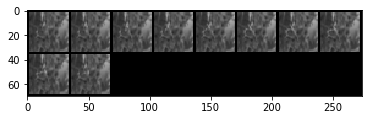

Process Process-2:
Process Process-1:
Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
KeyboardInterrupt
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
gif = dataiter.next()[0]

def imshow(img, save_file=None):
    npimg = img.numpy()
    out = np.transpose(npimg, (1, 2, 0))

    if save_file:
        plt.imsave(save_file, out)
        
    plt.imshow(out)
    
imshow(torchvision.utils.make_grid(gif))

# indx = 0
# try:
#     for i in range(3668, len(train_set)):
#         if i % 200 == 0:
#             print(i)
#         indx = i
#         x = train_set[i]

# except ValueError:
#     print(indx, train_set.filenames[indx])

    


In [7]:
def train_fn(model, optimizer, x):

    def loss_fn(a, b): 
        pass
            
    h0 = model.init_hidden(BATCH_SZ)

    model.train()            

    loss = 0.0


    
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return loss.item()

## Train network

In [8]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS   
HIDDEN_SIZE = INPUT_SIZE
OUTPUT_SIZE = INPUT_SIZE


net = RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        output_size=OUTPUT_SIZE, 
        num_layers=2, 
        cell_type='lstm', 
        device=device
     )

optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, nesterov=True)

In [9]:
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH)


print('Starting training...')
trainer.train(train_loader, epochs=5, save_every=20)

Starting training...
torch.Size([32, 10, 3072])
Epoch [0] (0/124), loss = 2.0399
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])
torch.Size([32, 10, 3072])


Process Process-7:
Process Process-5:
Process Process-8:
  File "/home/deepdeepfakes/cs231n-project/src/utils/data_utils.py", line 44, in __getitem__
    gif = self._file_to_gif_tensor(self.filenames[index])
  File "/home/deepdeepfakes/cs231n-project/src/utils/data_utils.py", line 33, in _file_to_gif_tensor
    frames = [self.transform(frame.copy().convert('RGB')) for frame in ImageSequence.Iterator(gif)]
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/deepdeepfakes/cs231n-project/src/utils/data_utils.py", line 33, in <listcomp>
    frames = [self.transform(frame.copy().convert('RGB')) for frame in ImageSequence.Iterator(gif)]
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/deepdeepfakes/cs231n-project/

RuntimeError: DataLoader worker (pid 5295) exited unexpectedly with exit code 1.

seeds: torch.Size([32, 1, 3072])
torch.Size([320, 3, 32, 32]) torch.Size([32, 10, 1, 3072])
torch.Size([320, 3, 32, 32]) torch.Size([320, 3, 32, 32])


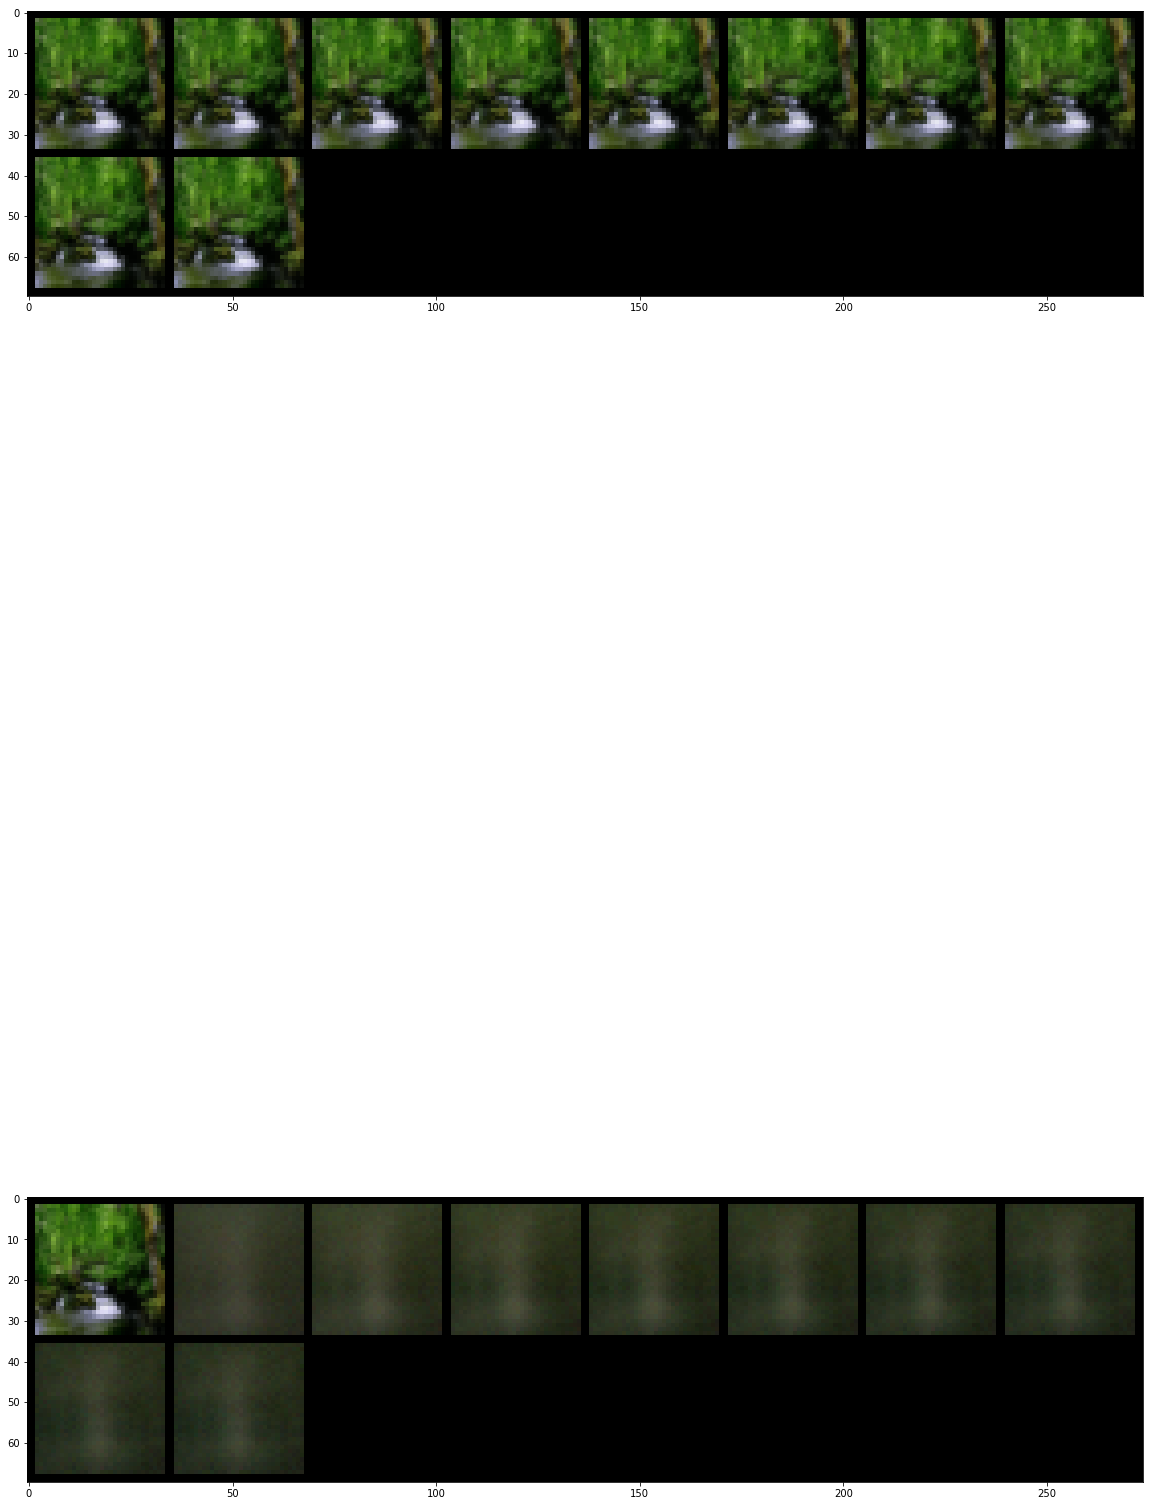

In [20]:
def sample(model, seed_frame, gif_length=10):
    curr_h = model.init_hidden(BATCH_SZ)
    curr_x = seed_frame.to(device=device, dtype=dtype)
    model.eval()
    ret = [seed_frame]
    
    for i in range(gif_length - 1):
        y, curr_h = model(curr_x, curr_h)
        curr_x = y   # TODO: maybe sample from probability?
        ret.append(y.to(device = torch.device('cpu')))
        
    
    return torch.stack(ret).transpose(0, 1)


plt.figure(figsize=(20,40))

    
def test_rnn(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    
    seeds = x[:, 0, :, :, :]
    seeds = lstm_flatten(torch.unsqueeze(seeds, 1))
    print(f'seeds: {seeds.shape}')

    orig_gifs = torch.cat(tuple(x))
    
    out_gifs = sample(model, seeds)
    
    
    print(orig_gifs.shape, out_gifs.shape)
    
    out_gifs = out_gifs.unsqueeze(2).view(BATCH_SZ, 10, 3, 32, 32).detach()
    out_gifs = out_gifs.contiguous().view(-1, 3, 32, 32)
    out_gifs = deprocess(out_gifs)
    
    print(orig_gifs.shape, out_gifs.shape)
    
    orig_gifs = orig_gifs[:10]
    out_gifs = out_gifs[:10]

#     final = torchvision.utils.make_grid(torch.cat(orig_gifs, out_gifs))

    plt.subplot(211)
    imshow(torchvision.utils.make_grid(orig_gifs)) #, save_file='img/train_test_orig.png')
    plt.subplot(212)
    
    imshow(torchvision.utils.make_grid(out_gifs)) #, save_file='img/train_test_out.png')
    
    
    
    
    

test_rnn(net, train_loader)